## MCF AFFORDABILITY SCORING MODEL.

- This model creates a weighted score for each applicant based on the most important factors (from Applicant & Bureau data) affecting the afford_flag from the random forest results

In [1]:
# Import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm   
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import os
# current_dir = os.getcwd()
# parent_dir = os.path.dirname(current_dir)
# subfolder = "4 approval_models"
# file1 = "scorecard2.xlsx"
# file_path1 = os.path.join(parent_dir, subfolder,file1)
# scorecard_df = pd.read_excel(file_path1)

# Import scorecard from file
scorecard_df = pd.read_excel('scorecard.xlsx')
scorecard_df.head()

,scorecard_item,band_start,band_finish,points,Max points,RF ranking,Unnamed: 6,0-Flag,1-Flag,% 1-Flag
0,DTI,0.0,9.0,60.0,60.0,1.0,NaN,1303.0,18.0,0.013626
1,DTI,10.0,19.0,55.0,NaN,NaN,NaN,5045.0,65.0,0.012720
2,DTI,20.0,29.0,45.0,NaN,NaN,NaN,6008.0,343.0,0.054007
3,DTI,30.0,39.0,20.0,NaN,NaN,NaN,2670.0,665.0,0.199400
4,DTI,40.0,49.0,10.0,NaN,NaN,NaN,546.0,565.0,0.508551


In [3]:
# Drop unnecessary columns
columns_to_drop = ['Max points', 'RF ranking', 'Unnamed: 6', '0-Flag', '1-Flag', '% 1-Flag']
scorecard_df = scorecard_df.drop(columns=columns_to_drop)

scorecard_df.head()

,scorecard_item,band_start,band_finish,points
0,DTI,0.0,9.0,60.0
1,DTI,10.0,19.0,55.0
2,DTI,20.0,29.0,45.0
3,DTI,30.0,39.0,20.0
4,DTI,40.0,49.0,10.0


In [4]:
# Import Model CSV file
applicants_df = pd.read_csv('df_model.csv')
applicants_df.head()

,uuid,date_created_x,amount_requested,duration_requested,reason,annual_salary,dependant_number,dependants_spend,has_mortgage_x,monthly_spending,...,has_mortgage_y,self_employed_flag,ccj_flag,missed_2+_payments_past_36m,o1,o2,o3,missed_payment,total_spend,DTI
0,50b53986-7471-4197-9f2a-7d6287eae8fa,2021-10-31,3500,24,home-improvements,72500,0,0.0,unknown,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.919407,3.011080
1,d8c5c75e-a5d0-462c-b6aa-634877364f74,2021-10-31,10000,60,debt,38079,1,400.0,unknown,1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,627.327456,19.769241
2,84057cd9-930f-469f-962b-711196323a15,2021-10-31,10000,48,vehicle,34500,0,0.0,unknown,1400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1091.147570,37.952959
3,99ac287b-9630-44e4-a74a-fc597d9dcb0d,2021-10-31,8500,60,debt,18000,0,0.0,unknown,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.728337,27.715222
4,11ae07c4-8fd1-415e-a70e-145776ad0072,2021-10-31,7000,60,other,25000,0,0.0,unknown,650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194.129219,9.318203


In [5]:
# View columns
applicants_df.columns

Index(['uuid', 'date_created_x', 'amount_requested', 'duration_requested',
       'reason', 'annual_salary', 'dependant_number', 'dependants_spend',
       'has_mortgage_x', 'monthly_spending', 'rent_mortgage_spend',
       'employment_status', 'number_applications', 'tax', 'net_salary',
       'monthly_earnings', 'clusters', 'disposable_income', 'rejected',
       'interest_rate', 'repayment', 'income_after_repay', 'date_created_y',
       'new_to_credit_on_date_created', 'salary_band_5000s',
       'salary_band_10000s', 'credit_score_100s', 'has_mortgage_y',
       'self_employed_flag', 'ccj_flag', 'missed_2+_payments_past_36m', 'o1',
       'o2', 'o3', 'missed_payment', 'total_spend', 'DTI'],
      dtype='object')

In [6]:
# Create an affordability flag

cushion = 0.10  # Percentage of EDI held in reserve by applicant

def calculate_afford_flag(row):
    afford_flag = (row['disposable_income'] * (1 - cushion)) - row['repayment']
    return afford_flag

applicants_df['afford_flag'] = applicants_df.apply(calculate_afford_flag, axis=1)
applicants_df['afford_flag'] = np.where(applicants_df['afford_flag'] > 0, 0, 1) 

In [7]:
columns_to_retain = ['uuid','DTI', 'monthly_spending', 'dependants_spend','has_mortgage_x', 'amount_requested','employment_status',
                     'credit_score_100s','duration_requested','reason', 'dependant_number','afford_flag']

# Select the desired columns and drop the rest
applicants_df = applicants_df[columns_to_retain]
applicants_df.dtypes

uuid                   object
DTI                   float64
monthly_spending        int64
dependants_spend      float64
has_mortgage_x         object
amount_requested        int64
employment_status      object
credit_score_100s     float64
duration_requested      int64
reason                 object
dependant_number        int64
afford_flag             int32
dtype: object

In [8]:
# Replace values in the 'has_mortgage_x' column
replacement_dict = {'True': 1, 'unknown': 0, 'False': 0}
applicants_df['has_mortgage_x'] = applicants_df['has_mortgage_x'].replace(replacement_dict)

In [9]:
# Define the new columns
new_columns = {
    'score_DTI': 0,
    'score_monthly_spending': 0,
    'score_dependants_spend': 0,
    'score_has_mortgage_x': 0,
    'score_amount_requested': 0,
    'score_employment_status': 0,
    'score_credit_score_100s': 0,
    'score_duration_requested': 0,
    'score_reason': 0,
    'score_dependant_number': 0,
    'total_score': 0
}

# Add the new columns to the dataframe
for column_name, initial_value in new_columns.items():
    applicants_df[column_name] = initial_value

In [10]:
# Move total column to the end
column_to_move = 'total_score'
other_columns = [col for col in applicants_df.columns if col != column_to_move]
new_order = other_columns + [column_to_move]
applicants_df = applicants_df[new_order]

In [11]:
# Assign score based on DTI
for index, row in applicants_df.iterrows():
    if row['DTI'] <= scorecard_df.iloc[0, 2]:
        applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[0, 3]
    elif row['DTI'] <= scorecard_df.iloc[1, 2]:
        applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[1, 3]
    elif row['DTI'] <= scorecard_df.iloc[2, 2]:
        applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[2, 3]
    elif row['DTI'] <= scorecard_df.iloc[3, 2]:
        applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[3, 3]
    elif row['DTI'] <= scorecard_df.iloc[4, 2]:
        applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[4, 3]
    else: applicants_df.at[index, 'score_DTI'] = scorecard_df.iloc[5, 3]

# Assign score based on monthly spending
for index, row in applicants_df.iterrows():
    if row['monthly_spending'] <= scorecard_df.iloc[6, 2]:
        applicants_df.at[index, 'score_monthly_spending'] = scorecard_df.iloc[6, 3]
    elif row['monthly_spending'] <= scorecard_df.iloc[7, 2]:
        applicants_df.at[index, 'score_monthly_spending'] = scorecard_df.iloc[7, 3]
    elif row['monthly_spending'] <= scorecard_df.iloc[8, 2]:
        applicants_df.at[index, 'score_monthly_spending'] = scorecard_df.iloc[8, 3]
    elif row['monthly_spending'] <= scorecard_df.iloc[9, 2]:
        applicants_df.at[index, 'score_monthly_spending'] = scorecard_df.iloc[9, 3]
    else: applicants_df.at[index, 'score_monthly_spending'] = scorecard_df.iloc[10, 3] 
       

In [12]:
# Assign scores - dependants_spend
for index, row in applicants_df.iterrows():
    if row['dependants_spend'] <= scorecard_df.iloc[11, 2]:
        applicants_df.at[index, 'score_dependants_spend'] = scorecard_df.iloc[11, 3]
    elif row['dependants_spend'] <= scorecard_df.iloc[12, 2]:
        applicants_df.at[index, 'score_dependants_spend'] = scorecard_df.iloc[12, 3]
    elif row['dependants_spend'] <= scorecard_df.iloc[13, 2]:
        applicants_df.at[index, 'score_dependants_spend'] = scorecard_df.iloc[13, 3]
    else: applicants_df.at[index, 'score_dependants_spend'] = scorecard_df.iloc[14, 3]
        
# Assign score based on 'has_mortgage'
for index, row in applicants_df.iterrows():
    if row['has_mortgage_x'] == scorecard_df.iloc[15, 2]:
        applicants_df.at[index, 'score_has_mortgage_x'] = scorecard_df.iloc[15, 3]
    else: applicants_df.at[index, 'score_has_mortgage_x'] = scorecard_df.iloc[16, 3]


In [13]:
# Assign score based on amount requested
for index, row in applicants_df.iterrows():
    if row['amount_requested'] <= scorecard_df.iloc[17, 2]:
        applicants_df.at[index, 'score_amount_requested'] = scorecard_df.iloc[17, 3]
    elif row['amount_requested'] <= scorecard_df.iloc[18, 2]:
        applicants_df.at[index, 'score_amount_requested'] = scorecard_df.iloc[18, 3]
    elif row['amount_requested'] <= scorecard_df.iloc[8, 2]:
        applicants_df.at[index, 'score_amount_requested'] = scorecard_df.iloc[19, 3]
    elif row['amount_requested'] <= scorecard_df.iloc[20, 2]:
        applicants_df.at[index, 'score_amount_requested'] = scorecard_df.iloc[20, 3]
    else: applicants_df.at[index, 'score_amount_requested'] = scorecard_df.iloc[21, 3] 

# Assign score based on employment status
for index, row in applicants_df.iterrows():
    if row['employment_status'] != 'FT_EMPLOYED':
        applicants_df.at[index, 'score_employment_status'] = scorecard_df.iloc[22, 3]
    else: applicants_df.at[index, 'score_employment_status'] = scorecard_df.iloc[23, 3]
        
# Assign score based on credit score
for index, row in applicants_df.iterrows():    
    if row['credit_score_100s'] <= scorecard_df.iloc[24, 2]:
        applicants_df.at[index, 'score_credit_score_100s'] = scorecard_df.iloc[24, 3]
    elif row['credit_score_100s'] <= scorecard_df.iloc[25, 2]:
        applicants_df.at[index, 'score_credit_score_100s'] = scorecard_df.iloc[25, 3]
    elif row['credit_score_100s'] <= scorecard_df.iloc[26, 2]:
        applicants_df.at[index, 'score_credit_score_100s'] = scorecard_df.iloc[26, 3]
    else: applicants_df.at[index, 'score_credit_score_100s'] = scorecard_df.iloc[27, 3]


In [14]:
# Assign score based on duration_requested
for index, row in applicants_df.iterrows():
    if row['duration_requested'] <= scorecard_df.iloc[28, 2]:
        applicants_df.at[index, 'score_duration_requested'] = scorecard_df.iloc[28, 3]
    elif row['duration_requested'] <= scorecard_df.iloc[29, 2]:
        applicants_df.at[index, 'score_duration_requested'] = scorecard_df.iloc[29, 3]
    elif row['duration_requested'] <= scorecard_df.iloc[30, 2]:
        applicants_df.at[index, 'score_duration_requested'] = scorecard_df.iloc[30, 3]
    elif row['duration_requested'] <= scorecard_df.iloc[31, 2]:
        applicants_df.at[index, 'score_duration_requested'] = scorecard_df.iloc[31, 3]
    else: applicants_df.at[index, 'score_duration_requested'] = scorecard_df.iloc[32, 3]

# Assign score based on reason
for index, row in applicants_df.iterrows():
    if row['reason'] == 'debt':
        applicants_df.at[index, 'score_reason'] = scorecard_df.iloc[33, 3]
    elif row['reason'] == 'home-improvements':
        applicants_df.at[index, 'score_reason'] = scorecard_df.iloc[34, 3]
    elif row['reason'] == 'other':
        applicants_df.at[index, 'score_reason'] = scorecard_df.iloc[35, 3]
    elif row['reason'] == 'purchase':
        applicants_df.at[index, 'score_reason'] = scorecard_df.iloc[36, 3]
    else: applicants_df.at[index, 'score_reason'] = scorecard_df.iloc[37, 3]      
                
# Assign scores - dependent number
for index, row in applicants_df.iterrows():
    if row['dependant_number'] <= scorecard_df.iloc[38, 2]:
        applicants_df.at[index, 'score_dependant_number'] = scorecard_df.iloc[38, 3]
    elif row['dependant_number'] <= scorecard_df.iloc[39, 2]:
        applicants_df.at[index, 'score_dependant_number'] = scorecard_df.iloc[39, 3]
    else: applicants_df.at[index, 'score_dependant_number'] = scorecard_df.iloc[40, 3]


In [15]:
# Add totals
for index, row in applicants_df.iterrows():    
    applicants_df['total_score'] =  (applicants_df['score_DTI'] + applicants_df['score_monthly_spending'] +
                                    applicants_df['score_dependants_spend'] + applicants_df['score_has_mortgage_x'] +
                                    applicants_df['score_amount_requested'] + applicants_df['score_employment_status'] +
                                    applicants_df['score_credit_score_100s'] + applicants_df['score_duration_requested'] +
                                    applicants_df['score_reason'] + applicants_df['score_dependant_number'])       
        
applicants_df.head(5)  

,uuid,DTI,monthly_spending,dependants_spend,has_mortgage_x,amount_requested,employment_status,credit_score_100s,duration_requested,reason,...,score_monthly_spending,score_dependants_spend,score_has_mortgage_x,score_amount_requested,score_employment_status,score_credit_score_100s,score_duration_requested,score_reason,score_dependant_number,total_score
0,50b53986-7471-4197-9f2a-7d6287eae8fa,3.011080,500,0.0,0,3500,FT_EMPLOYED,300.0,24,home-improvements,...,40,10,10,9,0,3,6,8,2,148
1,d8c5c75e-a5d0-462c-b6aa-634877364f74,19.769241,1000,400.0,0,10000,FT_EMPLOYED,500.0,60,debt,...,25,10,10,8,0,9,0,0,2,109
2,84057cd9-930f-469f-962b-711196323a15,37.952959,1400,0.0,0,10000,FT_EMPLOYED,400.0,48,vehicle,...,25,10,10,8,0,5,2,5,2,87
3,99ac287b-9630-44e4-a74a-fc597d9dcb0d,27.715222,500,0.0,0,8500,FT_EMPLOYED,500.0,60,debt,...,40,10,10,9,0,9,0,0,2,125
4,11ae07c4-8fd1-415e-a70e-145776ad0072,9.318203,650,0.0,0,7000,FT_EMPLOYED,400.0,60,other,...,40,10,10,9,0,5,0,6,2,137


--------------

In [16]:
selected_columns = [
    'score_DTI',
    'score_monthly_spending',
    'score_dependants_spend',
    'score_has_mortgage_x',
    'score_amount_requested',
    'score_employment_status',
    'score_credit_score_100s',
    'score_duration_requested',
    'score_reason',
    'score_dependant_number'
]

selected_data = applicants_df[selected_columns]
sum_of_columns = selected_data.sum()
sum_of_columns

score_DTI                   699475
score_monthly_spending      582070
score_dependants_spend      172169
score_has_mortgage_x        157190
score_amount_requested      142002
score_employment_status      13968
score_credit_score_100s      87890
score_duration_requested     45348
score_reason                 62207
score_dependant_number       32864
dtype: int64

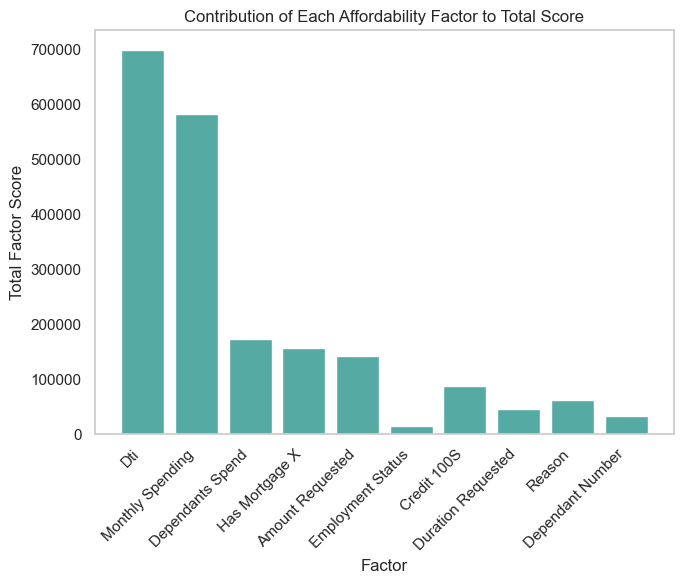

In [17]:
# Select style
sns.set(style="whitegrid")

# Replace labels in selected_columns
selected_columns = [label.replace("score_", "").replace("_", " ").title() for label in selected_columns]

# Specify the color for the bars
bar_color = '#55aaa4'  

# Plot contribution of each factor to total score
plt.figure(figsize=(7, 6))  
plt.bar(selected_columns, sum_of_columns, color=bar_color)  
plt.title('Contribution of Each Affordability Factor to Total Score')
plt.xlabel('Factor')  
plt.ylabel('Total Factor Score') 
plt.xticks(rotation=45, ha='right')

# Remove the grid
plt.grid(False)

plt.tight_layout()
plt.show()  

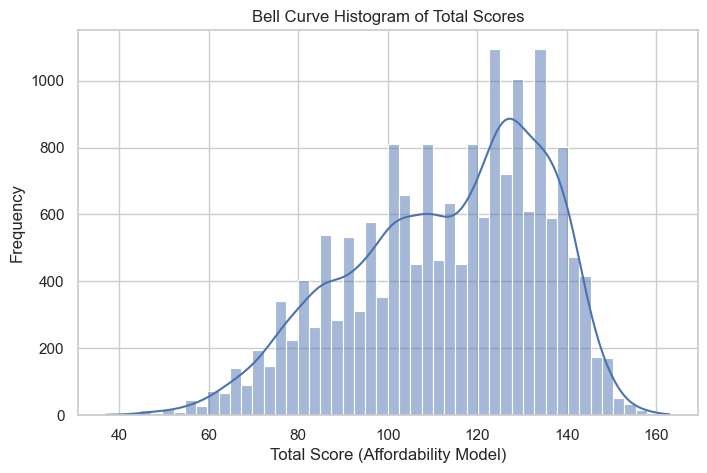

In [18]:
# Plot bell curve histogram
plt.figure(figsize=(8, 5))  
ax = sns.histplot(applicants_df['total_score'], kde=True)  # Create the histogram with KDE curve
ax.set_title('Bell Curve Histogram of Total Scores')
ax.set_xlabel('Total Score (Affordability Model)')  
ax.set_ylabel('Frequency') 
plt.show()  

In [19]:
# Perform Shapiro-Wilk test for normality
from scipy.stats import shapiro
statistic, p_value = shapiro(applicants_df['total_score'])

# Interpret the results
alpha = 0.05  # Significance level
print(f"Shapiro-Wilk Test: p-value = {p_value:.4f}")
if p_value > alpha:
    print("The data follows a normal distribution.")
else:
    print("The data does not follow a normal distribution.")

Shapiro-Wilk Test: p-value = 0.0000
The data does not follow a normal distribution.


### BLR model on 'Total Score'

In [20]:
# Assign variables
y = applicants_df['afford_flag']
X_data = applicants_df[['score_DTI','score_monthly_spending', 'score_dependants_spend', 'score_has_mortgage_x',
                        'score_amount_requested','score_employment_status','score_credit_score_100s',
                        'score_duration_requested', 'score_reason', 'score_dependant_number']]

In [21]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X_data, y,
                                                    test_size=0.3,
                                                    random_state=42)


In [22]:
# Log the index values for X before dataframe converted to array
original_indices = X_data.index

# Scale the X variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Apply SMOTE to balance y variable 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [24]:
# Create separate dataFrames for X and y:
resampled_data_X = pd.DataFrame(data=X_resampled)  
resampled_data_y = pd.DataFrame(data=y_resampled)

In [25]:
# Determine if data set is balanced.
print("Original data: ")
print(applicants_df['afford_flag'].value_counts())
print("Balanced data:")
print(resampled_data_y.value_counts())

Original data: 
0    15633
1     1975
Name: afford_flag, dtype: int64
Balanced data:
afford_flag
0              10948
1              10948
dtype: int64


In [26]:
# Import necessary libraries, packages, and classes.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

# Specify the model
logreg_model = LogisticRegression()
#logreg_model.fit(X_train, y_train)
logreg_model.fit(resampled_data_X, resampled_data_y) # Using balanced training data

LogisticRegression()

In [27]:
# Determine model accuracy by predicting test class:
y_pred = logreg_model.predict(X_test)

In [28]:
# Indicate the confusion matrix needs to be created.
conf_matrix = confusion_matrix(y_test, y_pred)

confusion = pd.DataFrame(conf_matrix, index=['No Flag', 'Afford Flag'],
                         columns=['Predicted No Flag', 'Predicted Afford Flag'])
confusion

,Predicted No Flag,Predicted Afford Flag
No Flag,4064,621
Afford Flag,75,523


In [29]:
# Print the accuracy and classification report.
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8682566723452584
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      4685
           1       0.46      0.87      0.60       598

    accuracy                           0.87      5283
   macro avg       0.72      0.87      0.76      5283
weighted avg       0.92      0.87      0.88      5283



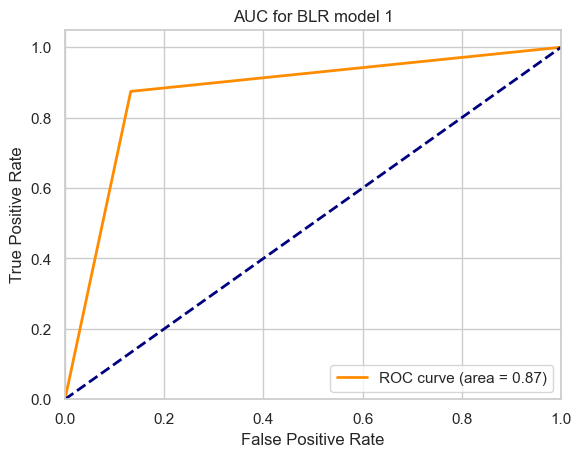

In [30]:
#Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

#Plot the AUC graph
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC for BLR model 1')
plt.legend(loc="lower right")
plt.show()

In [31]:
print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test:", y_test.shape)
print("Type of original_indices:", type(original_indices))

Shape of y_pred: (5283,)
Shape of y_test: (5283,)
Type of original_indices: <class 'pandas.core.indexes.range.RangeIndex'>


In [32]:
# Convert the arrays to Series to ensure 1-dimensional format
y_pred_series = pd.Series(y_pred)
y_test_series = y_test.squeeze() #Squeeze method converts into 1-D format

# Create a list of false positives
results_df = pd.DataFrame({'Prediction': y_pred_series, 'True_Label': y_test_series})

false_positives = results_df[(results_df['Prediction'] == 1) & (results_df['True_Label'] == 0)]

# Get the index values of false positives from the original DataFrame
false_positive_indices = original_indices[false_positives.index]

In [33]:
# Create a list of true positives
results_df2 = pd.DataFrame({'Prediction': y_pred_series, 'True_Label': y_test_series})

true_positives = results_df2[(results_df['Prediction'] == 1) & (results_df2['True_Label'] == 1)]

# Get the index values of false positives from the original DataFrame
true_positive_indices = original_indices[true_positives.index]

In [34]:
# List of uuids for false positives
false_positive_applicants = applicants_df.loc[false_positive_indices]

# Export to Excel
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

wb = Workbook()
sheet = wb.active
# Write column headers to the worksheet
header_row = [None] + false_positive_applicants.columns.tolist()  # Add None as the first element
sheet.append(header_row)

# Iterate over rows in the DataFrame
for idx, row in false_positive_applicants.iterrows():
    # Add index as the first column of each row
    row_data = [idx] + row.tolist()
    sheet.append(row_data)

# Save the workbook with the specified filename
import datetime
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')  # Format the datetime as a string
filename = f'False_Positives_Prop_Model {current_datetime}.xlsx'
wb.save(filename)

print(f"Workbook saved as '{filename}'")

Workbook saved as 'False_Positives_Prop_Model 2023-09-08_15-10-26.xlsx'


In [35]:
# Create another Excel file listing true positives
true_positive_applicants = applicants_df.loc[true_positive_indices]

# Export to Excel
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

wb = Workbook()
sheet = wb.active
# Write column headers to the worksheet
header_row = [None] + false_positive_applicants.columns.tolist()  # Add None as the first element
sheet.append(header_row)

# Iterate over rows in the DataFrame
for idx, row in true_positive_applicants.iterrows():
    # Add index as the first column of each row
    row_data = [idx] + row.tolist()
    sheet.append(row_data)

# Save the workbook with the specified filename
import datetime
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')  # Format the datetime as a string
filename = f'True_Positives_Prop_Model {current_datetime}.xlsx'
wb.save(filename)

print(f"Workbook saved as '{filename}'")

Workbook saved as 'True_Positives_Prop_Model 2023-09-08_15-10-26.xlsx'


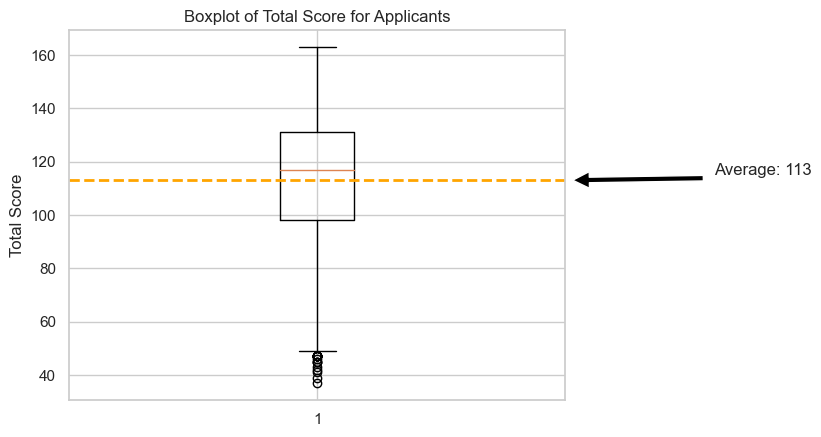

In [36]:
# Creates a boxplot for total scores of applicants
plt.boxplot(applicants_df['total_score'])

# Calculate the average value of the 'total_score' column
average_total_score = round(applicants_df['total_score'].mean())
# Add average value to plot
plt.axhline(average_total_score, color='orange', linestyle='dashed', linewidth=2, label='Average')
plt.annotate(f'Average: {average_total_score}', xy=(1.5, average_total_score), xytext=(1.8, average_total_score + 2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

# Add labels and title
plt.ylabel('Total Score')
plt.title('Boxplot of Total Score for Applicants')

plt.show()

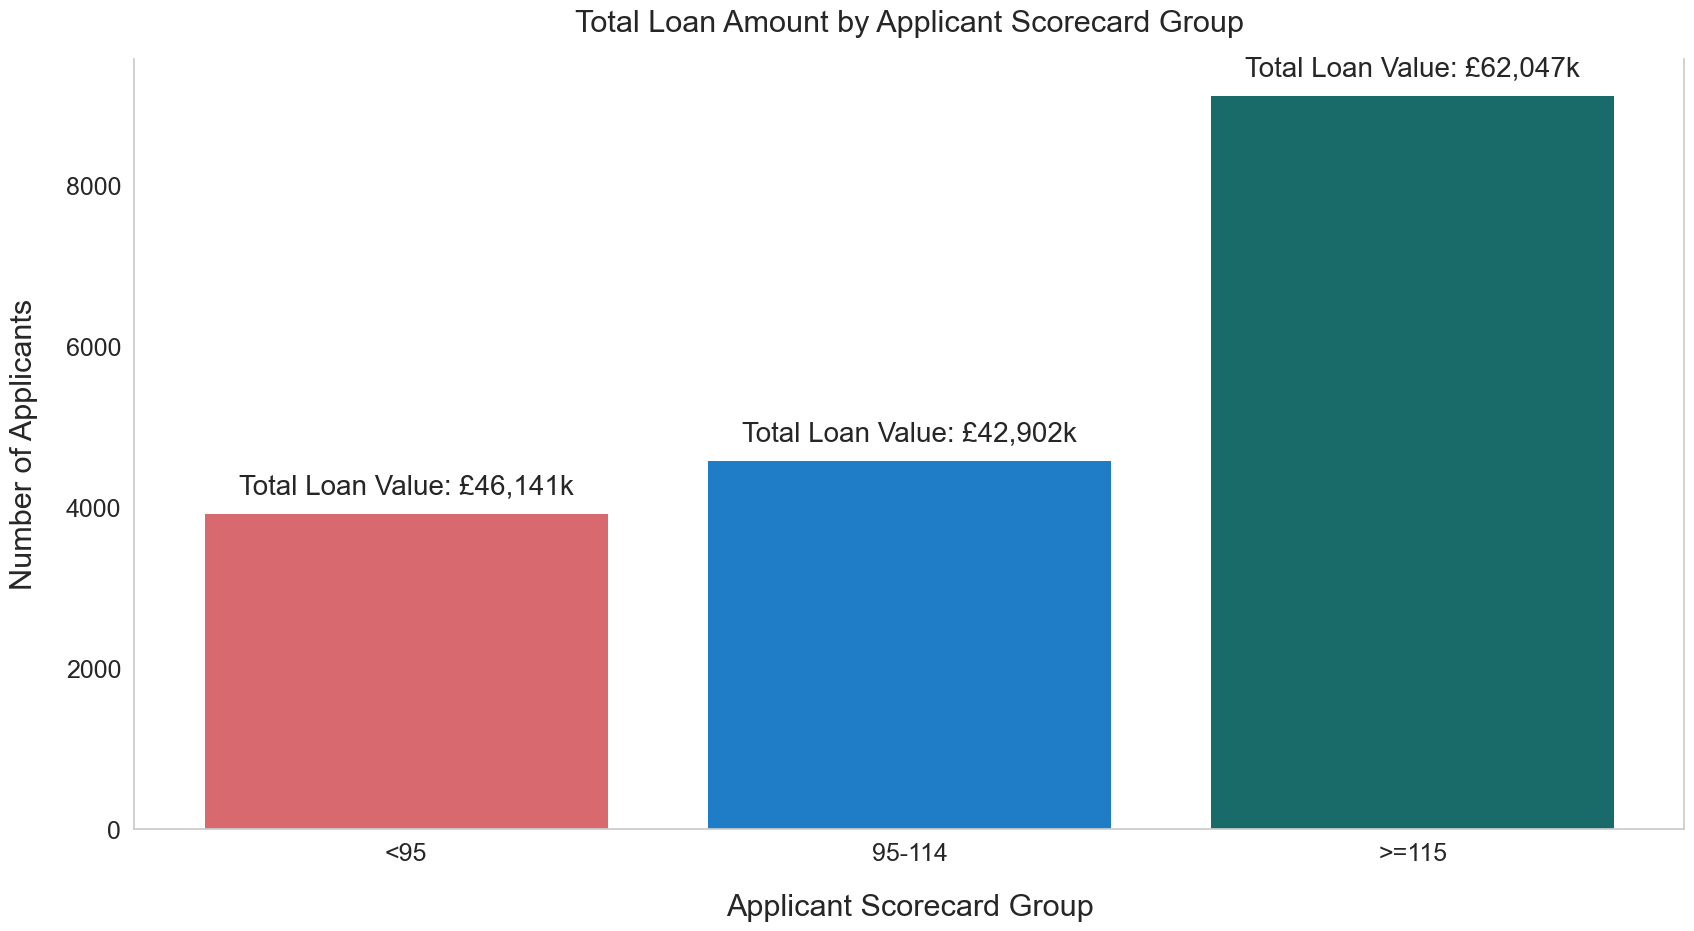

In [37]:
# Create histogram of distribution of 'total_score'

bins = [0, 95, 115, float('inf')]  # The last bin includes all scores over 

# Group the total_score into the bins
score_bins = pd.cut(applicants_df['total_score'], bins=bins, labels=['<95', '95-114', '>=115'])
bin_counts = score_bins.value_counts().sort_index()

# set colours for bars
mcf_colors = [ '#d8696f', '#1f7dc8', '#196b69']

# Increase the width by changing the figsize
plt.figure(figsize=(20, 10))  


# Create the bar plot
plt.bar(bin_counts.index, bin_counts.values, color=mcf_colors, edgecolor='none')

# Annotate with sum of loan amounts requested
bin_sum_amount = (applicants_df.groupby(score_bins)['amount_requested'].sum()).round(0).astype(int)
padding = 10  # Adjust the padding value
for i, value in enumerate(bin_sum_amount):
    formatted_value = '{:,.0f}'.format(value / 1000)
    plt.annotate(f'Total Loan Value: £{formatted_value}k', xy=(i, bin_counts[i]), ha='center', 
                 va='bottom', fontsize=20, textcoords='offset points', xytext=(0, padding) )
     
# Remove grid
plt.grid(False)

# Adjust the font size for tick labels on both x and y axes
plt.xticks(fontsize=18) 
plt.yticks(fontsize=18) 

# Remove the top spine (frame)
ax = plt.gca()
ax.spines['top'].set_visible(False)
  
    
# Add labels and title
plt.xlabel('Applicant Scorecard Group', fontsize=22, labelpad=20)
plt.ylabel('Number of Applicants', fontsize=22, labelpad=20)
plt.title('Total Loan Amount by Applicant Scorecard Group', pad=20, fontsize=22)

plt.show()

In [38]:
# Print score bins
print(np.unique(score_bins)) 

['95-114' '<95' '>=115']


In [39]:
# Create an empty dataframe
referred_applicants = pd.DataFrame(columns=['uuid', 'amount_requested', 'duration_requested', 'interest_rate'])

bin_labels = ['1' if x == '95-114' else '0' for x in score_bins]

# Determine indices of applicants falling into the second score bin
indices = []
for index, value in enumerate(bin_labels):
    if value == '1':
        indices.append(index)

# Loop through the indices and populate the referred_applicants dataframe
for index in indices:
    referred_applicants = referred_applicants.append({
        'uuid': applicants_df['uuid'].iloc[index],
        'amount_requested': applicants_df['amount_requested'].iloc[index],
        'duration_requested': applicants_df['duration_requested'].iloc[index],
        'interest_rate': 24.6
    }, ignore_index=True)

print(referred_applicants.shape)

# Export list to an Excel file
import datetime
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
excel_filename = f"referred_applicants_{current_datetime}.xlsx"
referred_applicants.to_excel(excel_filename, index=False)
print(f"Saved referred_applicants to {excel_filename}")

(4578, 4)
Saved referred_applicants to referred_applicants_2023-09-08_15-10-35.xlsx


> ### We use this CSV File for the cashflow model

----------

-------------------

In [40]:
# Define the score bins
bins = [0, 95, 115, float('inf')]  # The last bin includes all scores >= 115

# Create bins and count the applicants in each bin
score_bins = pd.cut(applicants_df['total_score'], bins=bins, labels=['<95', '95-114', '>=115'])
score_counts = score_bins.value_counts().sort_index()

# Calculate the percentage of total applicants
total_applicants = len(applicants_df)
score_percentages = (score_counts / total_applicants) * 100

# Create a DataFrame to display both counts and percentages
score_summary_df = pd.DataFrame({'Count': score_counts, 'Percentage': score_percentages})

# Print the summary DataFrame
print("Summary of Applicants by Score Range:")
print(score_summary_df)


Summary of Applicants by Score Range:
        Count  Percentage
<95      3912   22.217174
95-114   4578   25.999546
>=115    9118   51.783280


In [41]:
# Add column on to show which group each applicant is in
# Create histogram bins and bin names
bins = [0, 95, 115, float('inf')]
bin_names = ['Fail Affordability (under 95)', 'Borderline (95-114)', 'Good Affordability (115 and over)']

# Add a new column to the DataFrame with bin names
applicants_df['bin_name'] = pd.cut(applicants_df['total_score'], bins=bins, labels=bin_names)
applicants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   uuid                      17608 non-null  object  
 1   DTI                       17608 non-null  float64 
 2   monthly_spending          17608 non-null  int64   
 3   dependants_spend          17608 non-null  float64 
 4   has_mortgage_x            17608 non-null  int64   
 5   amount_requested          17608 non-null  int64   
 6   employment_status         17608 non-null  object  
 7   credit_score_100s         17608 non-null  float64 
 8   duration_requested        17608 non-null  int64   
 9   reason                    17608 non-null  object  
 10  dependant_number          17608 non-null  int64   
 11  afford_flag               17608 non-null  int32   
 12  score_DTI                 17608 non-null  int64   
 13  score_monthly_spending    17608 non-null  int6

In [42]:
# Create a groupby object to count applicants in each bin
bin_counts = applicants_df.groupby('bin_name')['total_score'].count()
bin_counts

bin_name
Fail Affordability (under 95)        3912
Borderline (95-114)                  4578
Good Affordability (115 and over)    9118
Name: total_score, dtype: int64

In [43]:
# Export csv with bin names on
# applicants_df.to_csv('applicants_scorecard.csv', index=False)

--------------------

--------------------------

## Clusters

In [44]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

In [45]:
# Import CSV files
aff = pd.read_csv('df_model.csv')

# Create a copy of dataframe
data = applicants_df.copy()

In [46]:
# View columns
data.columns

Index(['uuid', 'DTI', 'monthly_spending', 'dependants_spend', 'has_mortgage_x',
       'amount_requested', 'employment_status', 'credit_score_100s',
       'duration_requested', 'reason', 'dependant_number', 'afford_flag',
       'score_DTI', 'score_monthly_spending', 'score_dependants_spend',
       'score_has_mortgage_x', 'score_amount_requested',
       'score_employment_status', 'score_credit_score_100s',
       'score_duration_requested', 'score_reason', 'score_dependant_number',
       'total_score', 'bin_name'],
      dtype='object')

In [47]:
# View columns
aff.columns

Index(['uuid', 'date_created_x', 'amount_requested', 'duration_requested',
       'reason', 'annual_salary', 'dependant_number', 'dependants_spend',
       'has_mortgage_x', 'monthly_spending', 'rent_mortgage_spend',
       'employment_status', 'number_applications', 'tax', 'net_salary',
       'monthly_earnings', 'clusters', 'disposable_income', 'rejected',
       'interest_rate', 'repayment', 'income_after_repay', 'date_created_y',
       'new_to_credit_on_date_created', 'salary_band_5000s',
       'salary_band_10000s', 'credit_score_100s', 'has_mortgage_y',
       'self_employed_flag', 'ccj_flag', 'missed_2+_payments_past_36m', 'o1',
       'o2', 'o3', 'missed_payment', 'total_spend', 'DTI'],
      dtype='object')

In [48]:
# Descriptive statistics
aff['repayment'].describe()

count    17608.000000
mean       297.906953
std        173.355265
min         41.599118
25%        166.396473
50%        277.327456
75%        388.258438
max       2342.266530
Name: repayment, dtype: float64

In [49]:
# Merge the datasets to include income after repay
data2 = pd.merge(data, aff, on =["uuid"], how='left')

In [50]:
# Exclude people with no disposable income after repayment 
data2 = data2.drop(data2[data2['income_after_repay'] < 0].index)

In [51]:
# View shape
data2.shape

(15813, 60)

In [52]:
# Calculate proportion 
data2['DTDI'] = data2['repayment'] / data2['disposable_income'] * 100

In [53]:
# Descriptive statistics
data2['DTDI'].describe()

count    15813.000000
mean        26.872582
std         18.775006
min          1.003033
25%         13.523483
50%         21.668358
75%         34.618650
max         99.795291
Name: DTDI, dtype: float64

In [54]:
# Keep necessary columns
data3 = data2[['DTDI', 'total_score']]

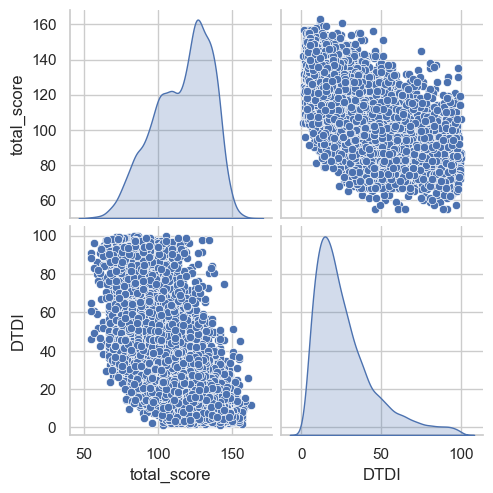

In [55]:
# Create a pairplot with Seaborn.
x = data3[['total_score', 'DTDI']]
sns.pairplot(data3,
             vars=x,
             diag_kind='kde')
plt.show()

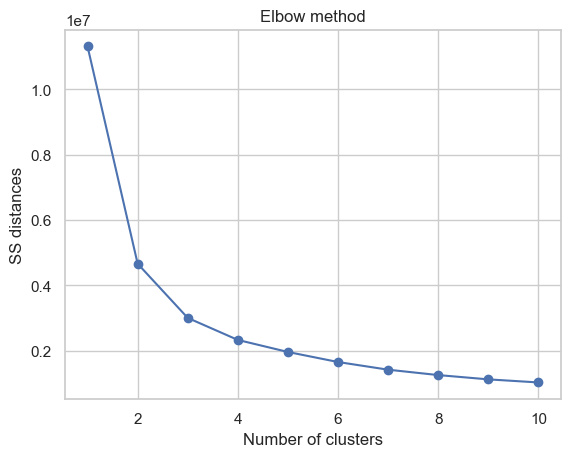

In [56]:
# Determine the number of clusters: Elbow method.
ss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(x)
    ss.append(kmeans.inertia_)
# plot the elbow method.
plt.plot(range(1, 11),
         ss,
         marker='o')
# insert labels and title
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("SS distances")
plt.show()

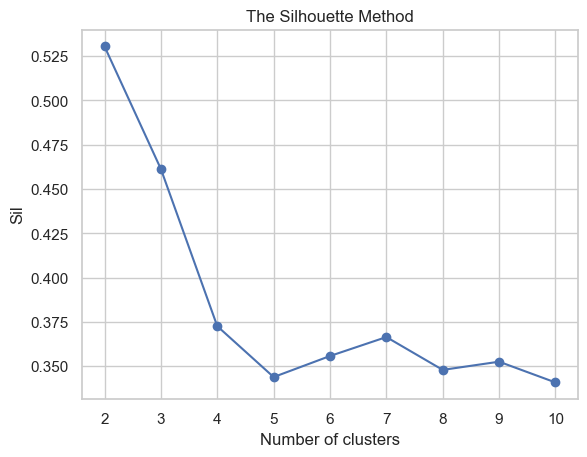

In [57]:
# Determine the number of clusters: Silhouette method.
sil = []
kmax = 10
for k in range(2, kmax+1):
    kmeans_s = KMeans(n_clusters=k).fit(x)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(x,
                                labels,
                               metric='euclidean'))
# plot the silhouette method
plt.plot(range(2, kmax+1),
         sil,
         marker='o')
# insert labels and title
plt.title("The Silhouette Method")
plt.xlabel("Number of clusters")
plt.ylabel("Sil")
plt.show()

### 1. Using 3 clusters

In [58]:
# use three clusters
kmeans = KMeans(n_clusters = 3,
                max_iter = 300,
                init='k-means++',
                random_state=0).fit(x)
clusters = kmeans.labels_
x['K-Means Predicted'] = clusters

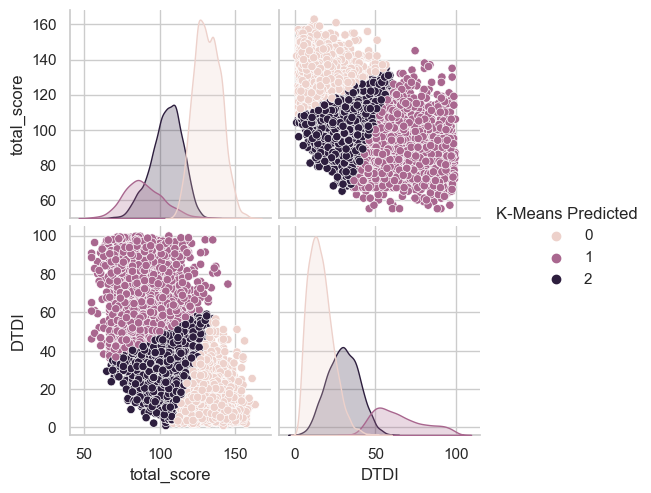

In [59]:
# plot three clusters
sns.pairplot(x,
             hue='K-Means Predicted',
             diag_kind='kde')
plt.show()

In [60]:
# Check the number of observations per predicted class.
x['K-Means Predicted'].value_counts()

0    8467
2    5211
1    2135
Name: K-Means Predicted, dtype: int64

In [61]:
# View the K-Means predicted.
print(x.head())

   total_score       DTDI  K-Means Predicted
0          148   4.360136                  0
1          109  27.785538                  2
2           87  94.513474                  1
3          125  32.313686                  0
4          137  15.832205                  0


In [62]:
# make a dataframe per cluster 
High_debt_low_score = x[x['K-Means Predicted'] == 1]
Med_debt_score = x[x['K-Means Predicted'] == 2]
Low_debt_high_score = x[x['K-Means Predicted'] == 0]

In [63]:
# Descriptive statistics
High_debt_low_score.describe()

,total_score,DTDI,K-Means Predicted
count,2135.000000,2135.000000,2135.0
mean,89.459016,64.333628,1.0
std,13.160536,15.124626,0.0
min,55.000000,36.257221,1.0
25%,80.000000,52.083328,1.0
50%,88.000000,61.362251,1.0
75%,98.000000,74.712085,1.0
max,145.000000,99.795291,1.0


In [64]:
# Descriptive statistics
Med_debt_score.describe()

,total_score,DTDI,K-Means Predicted
count,5211.000000,5211.000000,5211.0
mean,104.364230,29.762527,2.0
std,10.175567,9.748264,0.0
min,65.000000,1.003033,2.0
25%,98.000000,22.693038,2.0
50%,105.000000,29.770361,2.0
75%,112.000000,36.744860,2.0
max,135.000000,59.507124,2.0


In [65]:
# Descriptive statistics
Low_debt_high_score.describe()

,total_score,DTDI,K-Means Predicted
count,8467.000000,8467.000000,8467.0
mean,131.385733,15.647965,0.0
std,8.610177,7.561681,0.0
min,108.000000,1.018214,0.0
25%,125.000000,9.945536,0.0
50%,131.000000,14.658706,0.0
75%,138.000000,20.214703,0.0
max,163.000000,56.522506,0.0


> Low debt high score makes up around 56% of applicants

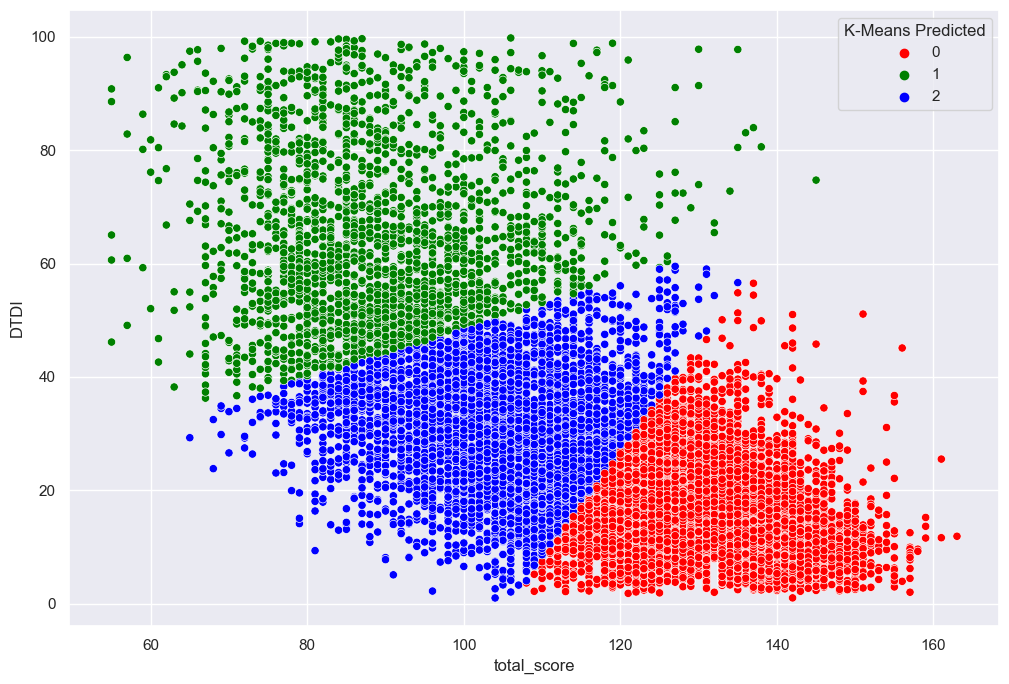

In [66]:
# Visualising the clusters.
# Set plot size.
sns.set(rc = {'figure.figsize':(12, 8)})

sns.scatterplot(x='total_score' , 
                y ='DTDI',
                data=x ,
                hue='K-Means Predicted',
                palette=['red', 'green', 'blue'])

plt.show()

### 2. Using 7 clusters

In [67]:
# use seven clusters
kmeans = KMeans(n_clusters = 7,
                max_iter = 300,
                init='k-means++',
                random_state=0).fit(x)
clusters = kmeans.labels_
x['K-Means Predicted'] = clusters

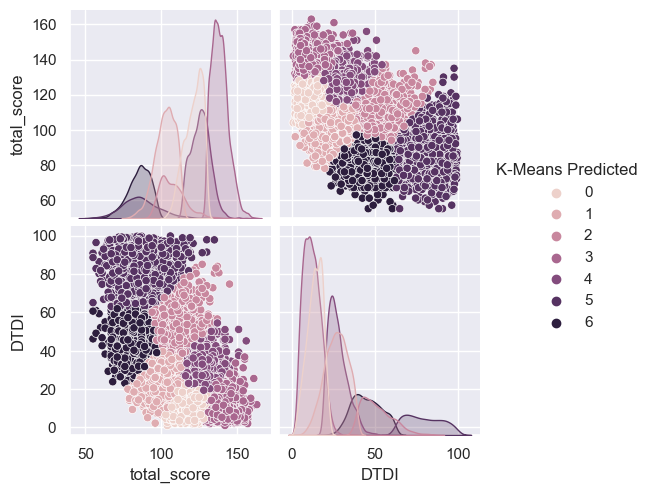

In [68]:
# plot seven clusters
sns.pairplot(x,
             hue='K-Means Predicted',
             diag_kind='kde')
plt.show()

In [69]:
# Check the number of observations per predicted class.
x['K-Means Predicted'].value_counts()

3    4004
0    3086
1    2821
4    2506
6    1398
2    1139
5     859
Name: K-Means Predicted, dtype: int64

In [70]:
# View the K-Means predicted.
print(x.head())

   total_score       DTDI  K-Means Predicted
0          148   4.360136                  3
1          109  27.785538                  1
2           87  94.513474                  5
3          125  32.313686                  4
4          137  15.832205                  3


In [71]:
# make a dataframe per cluster
excellent_score_low_debt = x[x['K-Means Predicted'] == 3]
high_score_low_debt = x[x['K-Means Predicted'] == 0]
high_score_moderate_debt = x[x['K-Means Predicted'] == 4]
moderate_score_low_debt = x[x['K-Means Predicted'] == 1]
moderate_score_high_debt = x[x['K-Means Predicted'] == 2]
low_score_moderate_debt = x[x['K-Means Predicted'] == 5]
low_score_high_debt = x[x['K-Means Predicted'] == 6]

In [72]:
# Descriptive statistics
excellent_score_low_debt.describe()

,total_score,DTDI,K-Means Predicted
count,4004.000000,4004.000000,4004.0
mean,138.416334,12.043597,3.0
std,5.488638,5.082250,0.0
min,129.000000,1.018214,3.0
25%,134.000000,8.052577,3.0
50%,138.000000,11.640383,3.0
75%,142.000000,15.553193,3.0
max,163.000000,36.721109,3.0


In [73]:
# Descriptive statistics
high_score_low_debt.describe()

,total_score,DTDI,K-Means Predicted
count,3086.000000,3086.000000,3086.0
mean,121.000972,13.907758,0.0
std,5.949245,4.580126,0.0
min,103.000000,1.003033,0.0
25%,117.000000,10.781909,0.0
50%,122.000000,14.312409,0.0
75%,126.000000,17.562637,0.0
max,130.000000,23.578925,0.0


In [74]:
# Descriptive statistics
high_score_moderate_debt.describe()

,total_score,DTDI,K-Means Predicted
count,2506.000000,2506.000000,2506.0
mean,125.760575,27.632881,4.0
std,6.214539,5.742913,0.0
min,114.000000,18.520019,4.0
25%,121.000000,23.295806,4.0
50%,126.000000,26.457321,4.0
75%,130.000000,30.978616,4.0
max,156.000000,54.431296,4.0


In [75]:
# Descriptive statistics
moderate_score_low_debt.describe()

,total_score,DTDI,K-Means Predicted
count,2821.000000,2821.000000,2821.0
mean,102.462602,26.658480,1.0
std,6.705383,6.919748,0.0
min,78.000000,2.219996,1.0
25%,98.000000,21.694740,1.0
50%,103.000000,27.002395,1.0
75%,108.000000,31.912381,1.0
max,114.000000,40.050154,1.0


In [76]:
# Descriptive statistics
moderate_score_high_debt.describe()

,total_score,DTDI,K-Means Predicted
count,1139.000000,1139.000000,1139.0
mean,107.290606,51.153803,2.0
std,8.263712,9.194705,0.0
min,93.000000,37.510093,2.0
25%,101.000000,43.656428,2.0
50%,106.000000,49.282747,2.0
75%,112.000000,56.633961,2.0
max,145.000000,85.026302,2.0


In [77]:
# Descriptive statistics
low_score_moderate_debt.describe()

,total_score,DTDI,K-Means Predicted
count,859.000000,859.000000,859.0
mean,86.399302,79.214890,5.0
std,12.155559,10.592921,0.0
min,55.000000,62.299565,5.0
25%,78.000000,69.890463,5.0
50%,85.000000,78.230841,5.0
75%,94.000000,88.150415,5.0
max,135.000000,99.795291,5.0


In [78]:
# Descriptive statistics
low_score_high_debt.describe()

,total_score,DTDI,K-Means Predicted
count,1398.000000,1398.000000,1398.0
mean,85.141631,45.087911,6.0
std,7.448317,8.707941,0.0
min,55.000000,23.052989,6.0
25%,80.000000,38.213118,6.0
50%,86.000000,44.430758,6.0
75%,91.000000,51.650766,6.0
max,98.000000,62.489287,6.0


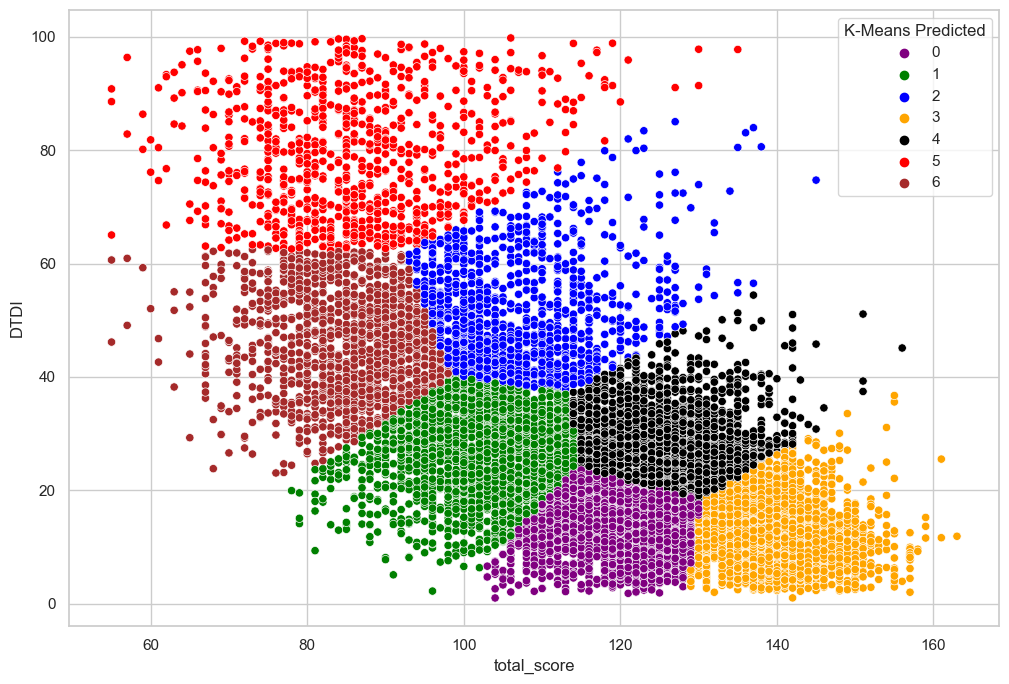

In [79]:
# Visualising the clusters.
# Set plot size.
sns.set(rc = {'figure.figsize':(12, 8)})
sns.set_style("whitegrid")

sns.scatterplot(x='total_score' , 
                y ='DTDI',
                data=x ,
                hue='K-Means Predicted',
                palette=['purple', 'green', 'blue', 'orange', 'black', 'red', 'brown'])

plt.show()

> The biggest group is group 3 which has high score and low debt to disposable income, therefore are low risk.

- 0: high_score_low_debt: 3086
- 1: moderate_score_low_debt: 2821
- 2: moderate_score_high_debt: 1139
- 3: excellent_score_low_debt: 4004
- 4: high_score_moderate_debt: 2506
- 5: low_score_moderate_debt: 859
- 6: low_score_high_debt: 1398

-----------------

> An Excel file generated from the above model with the reference name "referred_applicants_.xlsx", and can be used for the Cashflow Model

- Please move to next Jupiter notebook called:
    4.Team8_LSE_EP_Assignment3_Cashflow_Model 
    - This model generates a forecast cash flow for individual applicants.